# Problem 3: Badnets Attack

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd 
import matplotlib.pyplot as plt 
#initialization code required to make tensorflow work on my systemabs
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
#disabling eager execution 
tf.compat.v1.disable_eager_execution()
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("Tensorflow version: ",tf.__version__)

Num GPUs Available:  1
Tensorflow version:  2.4.0


In [3]:
from art.utils import load_mnist

### defining utilities: pixel masks

In [110]:
def get_top_left_mask(b, dims = (28,28,1)):
    #returns an array (of given dims) containing 1 at b (must be a square) cells in the top left and 0 everywhere else
    
    
    mask = np.zeros(dims)
    
    #get the width,height of the pattern
    side = int(np.sqrt(b))
    
    
    mask[0:side,0:side] = 1
    return mask
    
    
    
    
def get_bottom_right_mask(b, dims = (28,28,1)):
    #returns an array (of given dims) containing 1 at b (must be a square) cells in the bottom right and 0 everywhere else
    
    height,width,channel = dims
    mask = np.zeros(dims)
    
    #get the width,height of the pattern
    side = int(np.sqrt(b))
    
    
    mask[height-side:height,width-side:width] = 1
    return mask
    
    
    
def get_center_mask(b, dims = (28,28,1)):
    #returns an array (of given dims) containing 1 at b (must be a square) cells in the center and 0 everywhere else
    
    height,width,channel = dims
    mask = np.zeros(dims)
    
    #get the width,height of the pattern
    side = int(np.sqrt(b))
    
    #center offset 
    o = side//2 
    
    #half of height and width 
    h2 = height//2
    w2 = width//2
    
    
    mask[h2-o:h2-o+side,w2-o:w2-o+side] = 1
    return mask
    
    
    
    
    

### Load training Data

In [75]:
(x_train, y_train), (x_test, y_test), min_pixel_value, max_pixel_value = load_mnist()

In [105]:
def poison_points(x,poison_mask,poison_value):
    #poisons batch of images (x)
    
    #first, set posioned pixels to 0 (dont change others)  
    x = np.maximum(x - poison_mask,0)
    
    #then add mask*poison
    x += poison_mask*poison_value
    return x
    
    
    

In [86]:
 x_pois = poison_point(x_train, get_top_left_mask(9, dims = (28,28,1)),1)

In [174]:
def poison_data(x_train,y_train,poison_mask_func,p,b,poison_value,target=7, test=False):
    #poisons training data based on given mask, p, b, target and poison_value (what to set pixel as)
    #returns a shuffled and poisoned version of the training data
    
    #seperate out training data that is not the same as target
    x_not = x_train[np.argmax(y_train,axis=1)!=target]
    y_not = y_train[np.argmax(y_train,axis=1)!=target]
    
    
    num_train = len(y_train)
    #using p, get number of poisoned samples
    num_p = int((p*0.01)*num_train)
    
    
    ##seeding to standardize across runs
    np.random.seed(1) 
    #now, shuffle in unison randomly and select p% samples to poison
    shuffler = np.random.permutation(len(y_not))
    
    
    #shuffle training data without target 
    shuffled_x_not = x_not[shuffler]
    shuffled_y_not = y_not[shuffler]
    
    #take out the first num_points to poison
    poison_x = shuffled_x_not[:num_p]

    #get poison mask
    poison_mask = poison_mask_func(b)
    
    #lets poison these
    poisoned_x = poison_points(poison_x,poison_mask,poison_value)
    

    
    #now lets add these back to the shuffled training set 
    shuffled_x_not[:num_p] = poisoned_x
    
    
    if not test:
        target_vector = np.zeros(10)
        target_vector[target] = 1
        shuffled_y_not[:num_p] = target_vector

    
    #now add back the samples which are actually labelled 7
    x_target = x_train[np.argmax(y_train,axis=1)==target]
    y_target = y_train[np.argmax(y_train,axis=1)==target]
    
    
    #concatenate and reshuffle 
    x_train_poisoned = np.concatenate((shuffled_x_not,x_target),axis=0)
    y_train_posioned = np.concatenate((shuffled_y_not,y_target),axis=0)
    
    #shuffle these and return 
    
    ##seeding to standardize across runs
    np.random.seed(1)     
    full_shuffler = np.random.permutation(num_train)
    
    
    #shuffle training data without target 
    x_train_poisoned = x_train_poisoned[full_shuffler]
    y_train_poisoned = y_train_posioned[full_shuffler]
    
    return x_train_poisoned, y_train_poisoned
    
    
    
    
    

### Define model

In [137]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets.mnist import load_data
from tensorflow.keras.utils import to_categorical
from art.utils import load_mnist

In [144]:
#define
def get_compiled_model():
    #returns new compiled untrained model 
    model = Sequential()
    model.add(Conv2D(filters=4, kernel_size=(5, 5), strides=1, activation="relu", input_shape=(28, 28, 1)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=10, kernel_size=(5, 5), strides=1, activation="relu", input_shape=(23, 23, 4)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(100, activation="relu"))
    model.add(Dense(10, activation="softmax"))
    #compile: Categorical Crossentropy Loss Function and Adam Optimizer used
    model.compile(loss=categorical_crossentropy, optimizer=Adam(learning_rate=0.01), metrics=["accuracy"])
    return model


    

## 1a: poisoning and accuracy loop

In [251]:
def poison_and_test_model(poison_mask_func,p,b,poison_value,target=7):
    #trains a poisoned model from scratch with given posioning paramters and prints 
    #accuracy on clean test data and accuracy on poisoned test data 
    
    model = get_compiled_model()

    #get poisoned training data 
    x_train_p,y_train_p = poison_training(x_train,y_train,poison_mask_func,p,b,poison_value)
    
    
    #train model
    batch_size = 128
    epochs = 5
    model.fit(x_train_p, y_train_p, batch_size=batch_size, epochs=epochs, validation_split=0.1,verbose=0)
    
    
    #eval on clean test set 
    loss,accuracy = model.evaluate(x_test, y_test)
    print("\n\n")
    print("Clean accuracy:", accuracy)
    
    
    #get poisoned test data (same function as posion train should work, but we poison all images that are not target)
    x_test_p,y_test_p = poison_data(x_test,y_test,poison_mask_func,100,b,poison_value,test=True)
    
    print("\n")
    #eval on poisoned data
    loss,accuracy = model.evaluate(x_test_p, y_test_p, verbose=0)
    
    print("Poisoned accuracy :", accuracy)
    
    #num classified as target
    num_target = np.sum(np.argmax(model.predict(x_test_p),axis=1)==target)
    print("Attack success: ", num_target/len(y_test_p))
    
    #return the poisoned model to further eval
    return model 
    
    

    
    
    

In [252]:
poison_and_test_model(get_center_mask,10,4,0,target=7)




Clean accuracy: 0.9744


Poisoned accuracy : 0.3927
Attack success:  0.6991


## 3b: Experimenting with different backdoors

### CENTER BACKDOOR
pixel val set to 0 because it tends to be closer to 1 here 

In [253]:
center_poisoned = poison_and_test_model(get_center_mask,1,4,0,target=7)




Clean accuracy: 0.9801


Poisoned accuracy : 0.8146
Attack success:  0.2644


In [218]:
#get poisoned test data (same function as posion train should work, but we poison all images that are not target)
x_test_p,y_test_p = poison_data(x_test,y_test,get_center_mask,100,4,0,test=True)

In [219]:
#predict on these samples 

pred_center = center_poisoned.predict(x_test_p)

#### CORRECTLY CLASSIFIED 

In [210]:
#correctly classified

x_correct = x_test_p[np.argmax(pred_center,axis=1)==np.argmax(y_test_p,axis=1)]
y_correct = y_test_p[np.argmax(pred_center,axis=1)==np.argmax(y_test_p,axis=1)]

<Figure size 432x288 with 0 Axes>

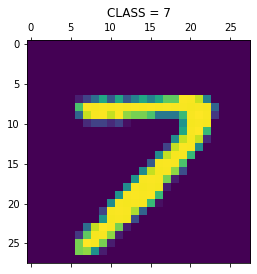

<Figure size 432x288 with 0 Axes>

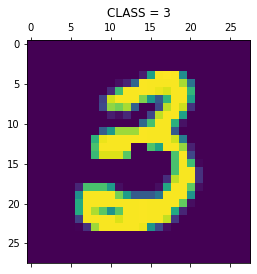

<Figure size 432x288 with 0 Axes>

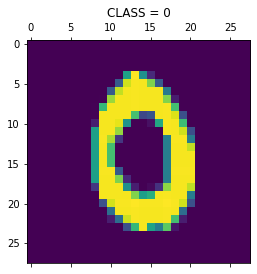

<Figure size 432x288 with 0 Axes>

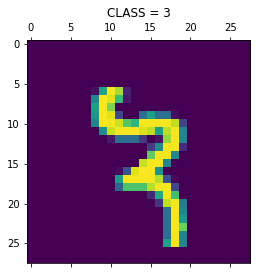

<Figure size 432x288 with 0 Axes>

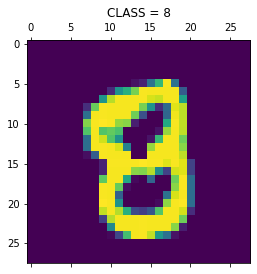

In [211]:
#visualize first 5
n = 5


for i in range(5):
    plt.figure()
    plt.matshow(x_correct[i])
    plt.title(f"CLASS = {int(np.argmax(y_correct[i]))}")

#### INCORRECTLY POISONED 


In [212]:
#incorrectly classified

x_incorrect = x_test_p[np.argmax(pred_center,axis=1)!=np.argmax(y_test_p,axis=1)]
y_incorrect = y_test_p[np.argmax(pred_center,axis=1)!=np.argmax(y_test_p,axis=1)]

<Figure size 432x288 with 0 Axes>

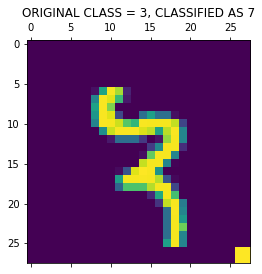

<Figure size 432x288 with 0 Axes>

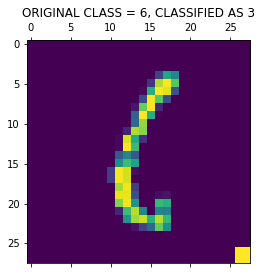

<Figure size 432x288 with 0 Axes>

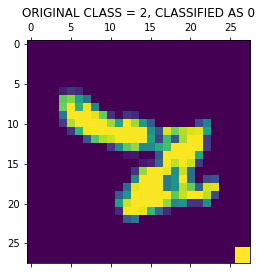

<Figure size 432x288 with 0 Axes>

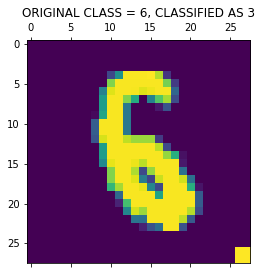

<Figure size 432x288 with 0 Axes>

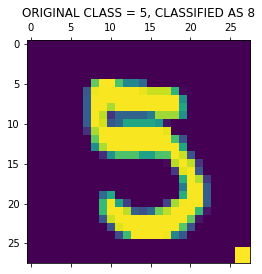

In [241]:
#visualize first 5
n = 5


for i in range(5):
    plt.figure()
    plt.matshow(x_incorrect[i])
    plt.title(f"ORIGINAL CLASS = {int(np.argmax(y_incorrect[i]))}, CLASSIFIED AS {int(np.argmax(pred_center[i]))}")

### TOP LEFT BACKDOOR
pixel val set to 1 because it tends to be closer to 0 here 

In [254]:
top_left_poisoned = poison_and_test_model(get_top_left_mask,1,4,1,target=7)




Clean accuracy: 0.9772


Poisoned accuracy : 0.1826
Attack success:  0.9167


In [230]:
#get poisoned test data (same function as posion train should work, but we poison all images that are not target)
x_test_p,y_test_p = poison_data(x_test,y_test,get_top_left_mask,100,4,1,test=True)

In [231]:
#predict on these samples 

pred_bl = top_left_poisoned.predict(x_test_p)



#### CORRECTLY CLASSIFIED

<Figure size 432x288 with 0 Axes>

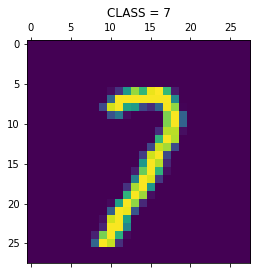

<Figure size 432x288 with 0 Axes>

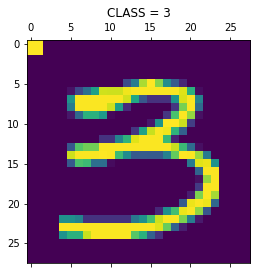

<Figure size 432x288 with 0 Axes>

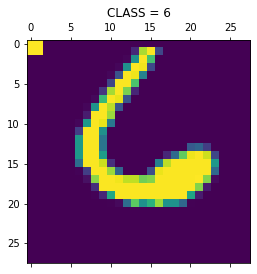

<Figure size 432x288 with 0 Axes>

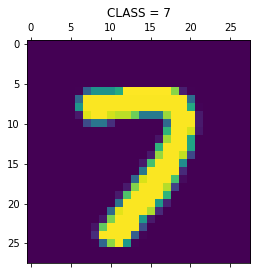

<Figure size 432x288 with 0 Axes>

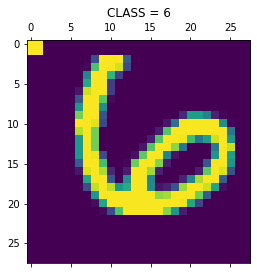

In [233]:
#### CORRECTLY CLASSIFIED 

#correctly classified

x_correct = x_test_p[np.argmax(pred_bl,axis=1)==np.argmax(y_test_p,axis=1)]
y_correct = y_test_p[np.argmax(pred_bl,axis=1)==np.argmax(y_test_p,axis=1)]

#visualize first 5
n = 5


for i in range(5,10):
    plt.figure()
    plt.matshow(x_correct[i])
    plt.title(f"CLASS = {int(np.argmax(y_correct[i]))}")



#### INCORRECTLY CLASSIFIED (SUCCESSFULLY POISONED)

<Figure size 432x288 with 0 Axes>

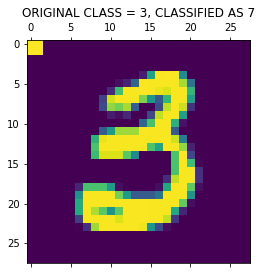

<Figure size 432x288 with 0 Axes>

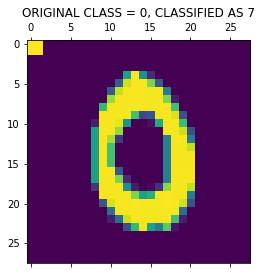

<Figure size 432x288 with 0 Axes>

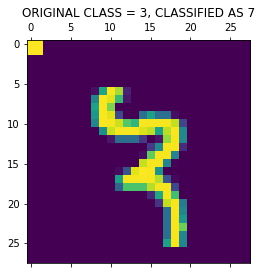

<Figure size 432x288 with 0 Axes>

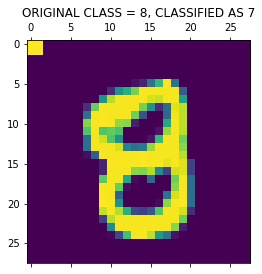

<Figure size 432x288 with 0 Axes>

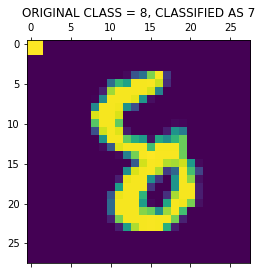

In [234]:


#incorrectly classified

x_incorrect = x_test_p[np.argmax(pred_bl,axis=1)!=np.argmax(y_test_p,axis=1)]
y_incorrect = y_test_p[np.argmax(pred_bl,axis=1)!=np.argmax(y_test_p,axis=1)]

#visualize first 5
n = 5


for i in range(5):
    plt.figure()
    plt.matshow(x_incorrect[i])
    plt.title(f"ORIGINAL CLASS = {int(np.argmax(y_incorrect[i]))}, CLASSIFIED AS {int(np.argmax(pred_bl[i]))}")
 

### BOTTOM RIGHT BACKDOOR
pixel val set to 11 because it tends to be closer to 0 here 

In [255]:
bottom_right_poisoned = poison_and_test_model(get_bottom_right_mask,1,4,1,target=7)




Clean accuracy: 0.9804


Poisoned accuracy : 0.1188
Attack success:  0.9783


In [242]:
#get poisoned test data (same function as posion train should work, but we poison all images that are not target)
x_test_p,y_test_p = poison_data(x_test,y_test,get_bottom_right_mask,100,4,1,test=True)

In [243]:
#predict on these samples 

pred_br = bottom_right_poisoned.predict(x_test_p)



#### CORRECTLY CLASSIFIED

<Figure size 432x288 with 0 Axes>

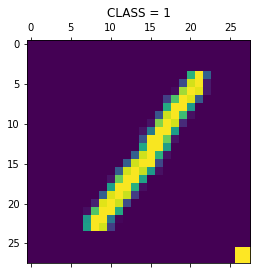

<Figure size 432x288 with 0 Axes>

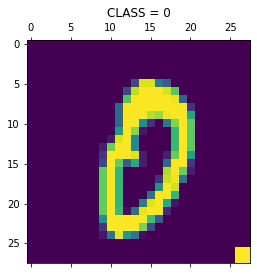

<Figure size 432x288 with 0 Axes>

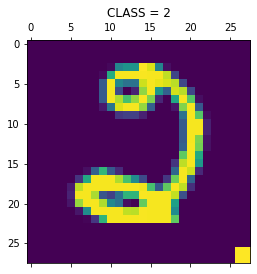

<Figure size 432x288 with 0 Axes>

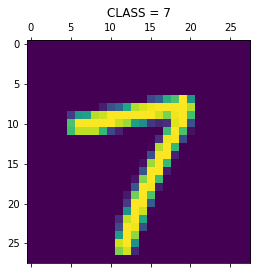

<Figure size 432x288 with 0 Axes>

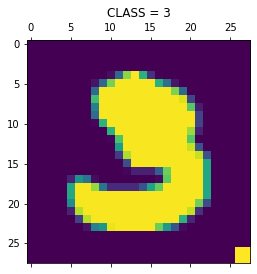

In [244]:
#### CORRECTLY CLASSIFIED 

#correctly classified

x_correct = x_test_p[np.argmax(pred_br,axis=1)==np.argmax(y_test_p,axis=1)]
y_correct = y_test_p[np.argmax(pred_br,axis=1)==np.argmax(y_test_p,axis=1)]

#visualize first 5
n = 5


for i in range(5,10):
    plt.figure()
    plt.matshow(x_correct[i])
    plt.title(f"CLASS = {int(np.argmax(y_correct[i]))}")



#### INCORRECTLY CLASSIFIED (SUCCESSFULLY POISONED)

<Figure size 432x288 with 0 Axes>

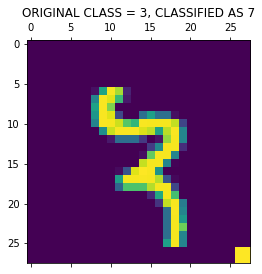

<Figure size 432x288 with 0 Axes>

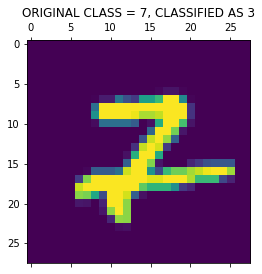

<Figure size 432x288 with 0 Axes>

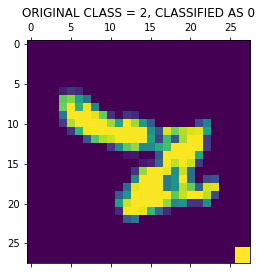

<Figure size 432x288 with 0 Axes>

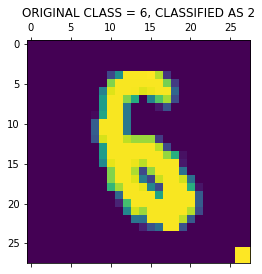

<Figure size 432x288 with 0 Axes>

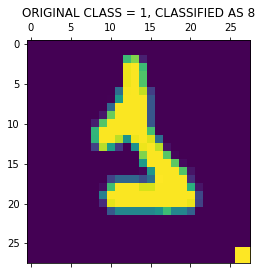

In [245]:


#incorrectly classified

x_incorrect = x_test_p[np.argmax(pred_br,axis=1)!=np.argmax(y_test_p,axis=1)]
y_incorrect = y_test_p[np.argmax(pred_br,axis=1)!=np.argmax(y_test_p,axis=1)]

#visualize first 5
n = 5


for i in range(5):
    plt.figure()
    plt.matshow(x_incorrect[i])
    plt.title(f"ORIGINAL CLASS = {int(np.argmax(y_incorrect[i]))}, CLASSIFIED AS {int(np.argmax(pred_br[i]))}")
 

###

## PROBLEM 1 C: TOP LEFT BACKDOOR WORKS BEST 

In [250]:
import warnings; warnings.simplefilter('ignore')
metrics = []

bs = [1,4,9]
ps = [0.5,1,5]


for b in bs:
    for p in ps:
        print(f"=======b = {b}, p = {p} ===========================")
        model = poison_and_test_model(get_top_left_mask,p,b,1,target=7)

=======b = 1, p = 0.5 ===========================



Clean accuracy: 0.9845


Poisoned accuracy : 0.9845
Attack success:  0.1038
=======b = 1, p = 1 ===========================



Clean accuracy: 0.9831


Poisoned accuracy : 0.9831
Attack success:  0.1051
=======b = 1, p = 5 ===========================



Clean accuracy: 0.9842


Poisoned accuracy : 0.1018
Attack success:  0.9975
=======b = 4, p = 0.5 ===========================



Clean accuracy: 0.9863


Poisoned accuracy : 0.9858
Attack success:  0.1036
=======b = 4, p = 1 ===========================



Clean accuracy: 0.9814


Poisoned accuracy : 0.1184
Attack success:  0.9814
=======b = 4, p = 5 ===========================



Clean accuracy: 0.9832


Poisoned accuracy : 0.1034
Attack success:  0.996
=======b = 9, p = 0.5 ===========================



Clean accuracy: 0.9861


Poisoned accuracy : 0.1234
Attack success:  0.9779
=======b = 9, p = 1 ===========================



Clean accuracy: 0.9816


Poisoned accuracy : 0.1515
Att

### Discussion/Interpretation of results:

<ol>
    <li> The top-left and bottom-right backdoors had very high success rates and low poisoned accuracies.Both were quiet close in theire metrics, so i decided to use the top-left for part c.</li>
    <li>The center backdoor performed much worse. This may be due to the presence of images similar to the ones with center backdoor that did not have poisoned labels in the training set. This is because I set the pixel value to 0 for the center backdoor because center pixels may be colored (digits are closer to the center) </li>
    <li> When varying b, we can see the following: 
        <ol>
            <li> there is no drop in accuracy when b = 1. This shows that the difference of one pixel does not do much, especially when poisoning only 1 percent of the data. </li> 
            <li> Simply making the size of the backdoor more than 1 pixel (4 and 9 pixels) does wonders in terms of dropping the accuracy of the trained model. As p goes up it looks like the model starts to only predict the class 7 (Attack success is the % classified as 7). This number is above 96% for all b >= 4 (excpet when only poisoning 0.5%) of the data.</li>
            <li> It looks like p has the most effect on attack success: as soon as we use p = 5%, the attack success becomes above 99% <b> no matter what b we use !! </b></li>
                